数据集大小: 37
Train Size:4  |  Test Size:33
['fan_id_02_abnormal', 'fan_id_02_normal', 'slider_id_02_abnormal', 'slider_id_02_normal', 'pump_id_02_abnormal', 'pump_id_02_normal', 'valve_id_02_abnormal', 'valve_id_02_normal']
时域波形形状: torch.Size([8, 160000])
频域波形形状: torch.Size([8, 2049, 626])
波形采样率: 16000


/tmp/ipykernel_68027/2397819842.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.plot(waveform[0].T.numpy())


<Figure size 640x480 with 0 Axes>

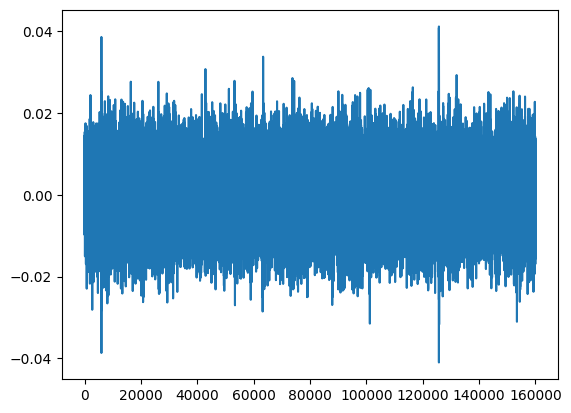

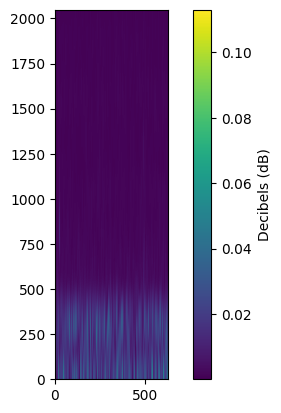

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, os, torch_geometric
import matplotlib.pyplot as plt
import datasets
from torch.utils.data import random_split, DataLoader
import utils, math

mimii_dataset_SNR = 0
N, K, query_size = 8, 3, 3
dataset_transform = 'spectrogram'
train_test_ratio = 0.1

args = utils.Args(seed=42, N=N, K=K, query_size=query_size, SNR=mimii_dataset_SNR, transform=dataset_transform)
if args.device != "cpu":
    num_workers = 1
    if N*K <= 32:
        pin_memory = True
    else:
        pin_memory = False
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

# 加载数据集
mimii_dataset = datasets.MIMII(root_dir=f'./data/mimii/{mimii_dataset_SNR}'+'dB_SNR',
                                machine_classes=['fan', 'pump', 'valve', 'slider'],
                                model_ids=['id_02'], categories=['normal', 'abnormal'],
                                N=N, K=K, query_size=query_size, transform='spectrogram', seed=args.seed)
print(f"数据集大小: {len(mimii_dataset)}")
train_size = math.ceil(train_test_ratio * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
train_set, test_set = random_split(mimii_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(args.seed))
train_loader = DataLoader(train_set, batch_size=1, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_set, batch_size=1, num_workers=num_workers, pin_memory=pin_memory)
print(f"Train Size:{train_size}  |  Test Size:{test_size}")
print(mimii_dataset.N_classes)

# 可视化一个样本
fig = plt.figure()
waveform_shape = 0
freq_waveform_shape = 0
for support_set, query_set in train_loader:
    for waveform, freq_waveform, label in query_set:
        waveform = waveform.squeeze(0)
        freq_waveform = freq_waveform.squeeze(0)
        print("时域波形形状: {}".format(waveform.size()))
        print("频域波形形状: {}".format(freq_waveform.size()))
        print("波形采样率: {}".format(mimii_dataset.sample_rate))
        plt.figure()
        plt.plot(waveform[0].T.numpy())
        plt.figure()
        plt.imshow(freq_waveform[0], origin='lower')
        plt.colorbar(label="Decibels (dB)")
        waveform_shape = waveform.shape
        freq_waveform_shape = freq_waveform.shape
        break
    break

Epoch:1  |  Time_CNN_Loss :0.138334  |  Freq_CNN_Loss :0.082607
Epoch:2  |  Time_CNN_Loss :0.057539  |  Freq_CNN_Loss :0.049798
Epoch:3  |  Time_CNN_Loss :0.035792  |  Freq_CNN_Loss :0.034691
Epoch:4  |  Time_CNN_Loss :0.027191  |  Freq_CNN_Loss :0.028523
Epoch:5  |  Time_CNN_Loss :0.020360  |  Freq_CNN_Loss :0.026402
Epoch:6  |  Time_CNN_Loss :0.016757  |  Freq_CNN_Loss :0.021708
Epoch:7  |  Time_CNN_Loss :0.014025  |  Freq_CNN_Loss :0.020292
Epoch:8  |  Time_CNN_Loss :0.011427  |  Freq_CNN_Loss :0.018707
Epoch:9  |  Time_CNN_Loss :0.009818  |  Freq_CNN_Loss :0.016842
Epoch:10  |  Time_CNN_Loss :0.007582  |  Freq_CNN_Loss :0.015693
Epoch:11  |  Time_CNN_Loss :0.006238  |  Freq_CNN_Loss :0.014418
Epoch:12  |  Time_CNN_Loss :0.004156  |  Freq_CNN_Loss :0.013908
Epoch:13  |  Time_CNN_Loss :0.003139  |  Freq_CNN_Loss :0.012453
Epoch:14  |  Time_CNN_Loss :0.002130  |  Freq_CNN_Loss :0.011982
Epoch:15  |  Time_CNN_Loss :0.001593  |  Freq_CNN_Loss :0.011022
Epoch:16  |  Time_CNN_Loss :0.0011

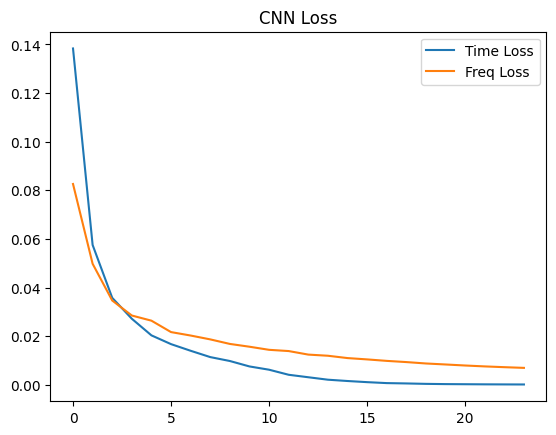

In [2]:
import nets
# CNN训练
time_cnn_num_hidden_channels = 64
freq_cnn_num_hidden_channels = 32
cnn_num_epochs = 24
time_cnn_lr = 0.05
freq_cnn_lr = 0.1

time_cnn = nets.AudioCNN(num_channels_input=waveform_shape[0], 
                        num_channels_hidden=time_cnn_num_hidden_channels, 
                        num_classes_output=args.N)
freq_cnn = nets.AudioCNN2D(num_channels_input=freq_waveform_shape[0], 
                        num_channels_hidden=freq_cnn_num_hidden_channels, 
                        num_classes_output=args.N)
    
def cnn_train(time_cnn, freq_cnn, train_loader, num_epochs, time_cnn_lr, freq_cnn_lr, args:utils.Args):

    def init_weights(module):
        if isinstance(module, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(module.weight)
            #nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

    time_optimizer = optim.Adam(time_cnn.parameters(), lr=time_cnn_lr) # , weight_decay=0.0001
    freq_optimizer = optim.Adam(freq_cnn.parameters(), lr=freq_cnn_lr) # , weight_decay=0.0001
    time_scheduler = optim.lr_scheduler.StepLR(time_optimizer, step_size=12, gamma=0.95)
    freq_scheduler = optim.lr_scheduler.StepLR(freq_optimizer, step_size=12, gamma=0.75)
    loss_function = nn.CrossEntropyLoss()
    freq_cnn.to(args.device).train()
    freq_cnn.apply(init_weights)
    time_cnn.to(args.device).train()
    time_cnn.apply(init_weights)
    time_losses = []
    freq_losses = []

    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(3) # 一个epoch经过样本数 time_cnn一个epoch所有样本损失总量
        for support_set, query_set in train_loader:
            waveforms, freq_waveforms, labels = [], [], []
            for waveform, freq_waveform, label in support_set:
                waveforms.append(waveform.squeeze(0))
                freq_waveforms.append(freq_waveform.squeeze(0))
                labels.append(label)
            # for waveform, freq_waveform, label in query_set:
            #     waveforms.append(waveform.squeeze(0))
            #     freq_waveforms.append(freq_waveform.squeeze(0))
            #     labels.append(label)
            labels = torch.tensor(labels, device=args.device)
            
            # 时域CNN 训练部分
            waveforms = torch.stack(waveforms).to(args.device)
            time_optimizer.zero_grad()
            time_y_hat = time_cnn(waveforms)
            loss = loss_function(time_y_hat, labels)
            loss.backward()
            time_loss = loss.item()
            time_optimizer.step()
            time_scheduler.step()
            del waveforms

            # 频域CNN 训练部分
            freq_waveforms = torch.stack(freq_waveforms).to(args.device)
            freq_optimizer.zero_grad()
            freq_y_hat = freq_cnn(freq_waveforms)
            loss = loss_function(freq_y_hat, labels)
            loss.backward()
            freq_loss = loss.item()
            freq_optimizer.step()
            freq_scheduler.step()
            metric.add(freq_waveforms.shape[0], time_loss, freq_loss)
            del freq_waveform, labels
            torch.cuda.empty_cache()
        
        time_losses.append(metric[1] / metric[0])
        freq_losses.append(metric[2] / metric[0])
        print(f"Epoch:{epoch}  |  Time_CNN_Loss :{time_losses[-1]:.6f}  |  Freq_CNN_Loss :{freq_losses[-1]:.6f}")
        
    fig = plt.figure()
    plt.plot(list(range(num_epochs)), time_losses, label='Time Loss')
    plt.plot(list(range(num_epochs)), freq_losses, label='Freq Loss')
    plt.title('CNN Loss')
    plt.legend()
    res_folder = f"./Results/{args.N}-way-{args.K}-shots"
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    plt.savefig(os.path.join(res_folder, f"{args.SNR}SNR-cnn-train-res-{args.N}-way-{args.K}-shots-"+args.transform))

cnn_train(time_cnn, freq_cnn, train_loader, num_epochs=cnn_num_epochs, 
          time_cnn_lr=time_cnn_lr, freq_cnn_lr=freq_cnn_lr, args=args)

In [3]:
from torch_geometric.data import Data
def graph_construction(feature_vecs, labels):
    """返回一个torch_geometric.data.Data类, 代表一张图"""
    num_nodes = feature_vecs.shape[0]
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            adj_matrix[i][j] = 1 / (torch.sum(torch.sqrt(torch.pow(feature_vecs[i] - feature_vecs[j], 2)), 0)+torch.tensor(1e-5))
    edge_index, edge_weight = torch_geometric.utils.dense_to_sparse(adj_matrix)
    return Data(x=feature_vecs, edge_index=edge_index, edge_weight=edge_weight, y=labels)

def to_graph_dataset(time_cnn:nn.Module, freq_cnn:nn.Module, dataloader:torch.utils.data.DataLoader, args):
    """
    Device指的是CNN的device, 而不是最终形成的graph的device\n
    最终的graph会被放在cpu上
    """
    time_graphs, freq_graphs = [], []
    for support_set, query_set in dataloader:
        waveforms, freq_waveforms, labels = [], [], []
        for waveform, freq_waveform, label in support_set:
            waveforms.append(waveform.squeeze(0))
            freq_waveforms.append(freq_waveform.squeeze(0))
            labels.append(label)
        for waveform, freq_waveform, label in query_set:
            waveforms.append(waveform.squeeze(0))
            freq_waveforms.append(freq_waveform.squeeze(0))
            labels.append(label)
        
        waveforms = torch.stack(waveforms).to(args.device)
        labels = torch.tensor(labels, device=args.device)
        time_feature_vecs = torch.tensor(10.) * utils.feature_extraction(time_cnn, waveforms)
        del waveforms
        torch.cuda.empty_cache()

        freq_waveforms = torch.stack(freq_waveforms).to(args.device)
        freq_feature_vecs = torch.tensor(10.) * utils.feature_extraction(freq_cnn, freq_waveforms)
        del freq_waveforms
        torch.cuda.empty_cache()
        
        time_graph = graph_construction(time_feature_vecs, labels)
        freq_graph = graph_construction(freq_feature_vecs, labels)
        time_graphs.append(time_graph)
        freq_graphs.append(freq_graph)

    return time_graphs, freq_graphs

from torch_geometric.loader import DataLoader as GeometricDataLoader
time_graphs, freq_graphs = to_graph_dataset(time_cnn, freq_cnn, train_loader, args)
time_graph_dataset = datasets.GraphDataset(graphs=time_graphs)
freq_graph_dataset = datasets.GraphDataset(graphs=freq_graphs)
query_size = mimii_dataset.query_size
time_graph_trainloader = GeometricDataLoader(time_graph_dataset, batch_size=1)
freq_graph_trainloader = GeometricDataLoader(freq_graph_dataset, batch_size=1)
print(f"图训练数据集中共有{len(time_graph_trainloader)}张图")

图训练数据集中共有4张图


Epoch:50  |  GCN_Loss :0.00000  |  Query_Acc:100.00%
Epoch:100  |  GCN_Loss :0.00000  |  Query_Acc:100.00%
Epoch:150  |  GCN_Loss :0.00000  |  Query_Acc:100.00%
Epoch:200  |  GCN_Loss :0.00000  |  Query_Acc:100.00%


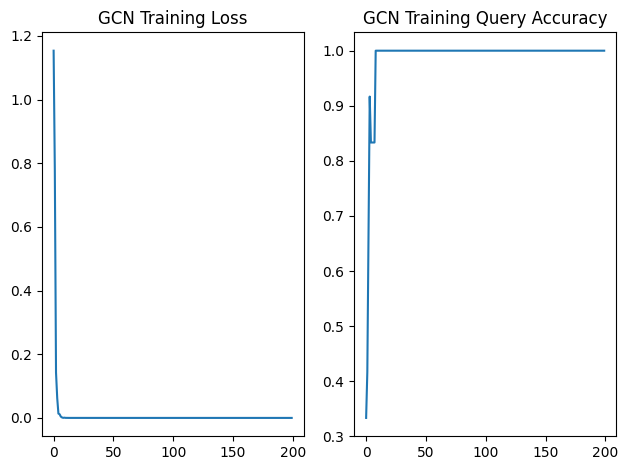

In [7]:
from torch_geometric.nn import GCNConv
from torch.nn import functional as F

# GCN训练
def gcn_train(ensemble_gcn, time_graph_trainloader, freq_graph_trainloader, query_size, num_epochs, lr, args:utils.Args):

    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            #nn.init.normal_(module.weight, mean=0, std=1. / (10 ** 0.5))
        elif isinstance(module, torch_geometric.nn.GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)
            #nn.init.normal_(module.lin.weight, mean=0, std=1. / (10 ** 0.5))

    def get_num_correct_query_pred(pred_y, y, query_size):
        return torch.sum(pred_y[-query_size:].argmax(dim=1) == y[-query_size:])

    optimizer = optim.Adam(gcn.parameters(), lr=lr, weight_decay=0.0001) # , weight_decay=0.0001
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85)
    loss_function = nn.CrossEntropyLoss()
    gcn.to(args.device).train()
    gcn.apply(init_weights)
    _, axes = plt.subplots(1, 2)

    losses, accs = [], []
    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(4) # 一个epoch经过样本数 gcn一个epoch所有样本损失总量 一个epoch的query总数 一个epoch正确分类的query总数
        for time_graph, freq_graph in zip(time_graph_trainloader, freq_graph_trainloader):
            time_features, y = time_graph.x.to(args.device), time_graph.y.to(args.device)
            freq_features = freq_graph.x.to(args.device)
            edge_index, time_edge_weight = time_graph.edge_index.to(args.device), time_graph.edge_weight.to(args.device)
            freq_edge_weight = freq_graph.edge_weight.to(args.device)
            optimizer.zero_grad()
            y_hat = ensemble_gcn(time_features, edge_index, time_edge_weight,
                                 freq_features, freq_edge_weight, y, args.N, args.query_size)
            loss = loss_function(y_hat, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                metric.add(time_features.shape[0], loss.item(),
                           query_size, get_num_correct_query_pred(y_hat, y, query_size))
            del time_features, freq_features, y, edge_index, time_edge_weight, freq_edge_weight
            torch.cuda.empty_cache()
                
        losses.append(metric[1] / metric[0])
        accs.append(metric[3] / metric[2])

        if epoch % 50==0:
            print(f"Epoch:{epoch}  |  GCN_Loss :{losses[-1]:.5f}  |  Query_Acc:{metric[3]/metric[2]*100:.2f}%")

    axes[0].plot(list(range(num_epochs)), losses)
    axes[0].set_title('GCN Training Loss')
    axes[1].plot(list(range(num_epochs)), accs)
    axes[1].set_title('GCN Training Query Accuracy')

    plt.tight_layout()
    res_folder = f"./Results/{args.N}-way-{args.K}-shots"
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    plt.savefig(os.path.join(res_folder, f"{args.SNR}SNR-gcn-train-res-{args.N}-way-{args.K}-shots-"+args.transform))

"""
GCN架构:
将time_features送入一个time_GCN, 将freq_features送入一个frea_GCN,
得到图卷积后的两种特征形状为 [n_samples, time_gcn_embed_sz] 和 [n_samples, freq_gcn_embed_sz]
连接两种特征 -> features.shape = [n_samples ,time_gcn_embed_sz+freq_gcn_embed_sz]
连接后的特征送入一个GCN, 再次卷积 -> [n_samples, gcn_embed_sz] -> [Linear] -> n_classes
"""
class EnsembleGCN(nn.Module):
    def __init__(self, num_time_features_inputs, num_freq_features_inputs, 
                 time_embed_size, freq_embed_size, embed_size, num_classes_output):
        super().__init__()
        self.time_gconv = GCNConv(num_time_features_inputs, time_embed_size)
        self.freq_gconv = GCNConv(num_freq_features_inputs, freq_embed_size)
        self.concat_gconv = GCNConv(time_embed_size+freq_embed_size+num_classes_output, embed_size)
        self.out = nn.Linear(embed_size, num_classes_output)

    def to_one_hot(self, labels, num_classes, query_size):
        num_samples = labels.shape[0]
        one_hot = torch.zeros((num_samples, num_classes), device=labels.device)
        one_hot[:num_samples-query_size, labels] = 1

        return one_hot

    def graph_construction(self, feature_vecs, num_classes):
        """内嵌于EnsembleGCN的更新连接权重的函数"""
        num_nodes, vec_len = feature_vecs.shape[0], feature_vecs.shape[1]
        adj_matrix = torch.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i == j:
                    continue
                adj_matrix[i][j] = 1 / (torch.sum(torch.sqrt(torch.pow(feature_vecs[i, :vec_len-num_classes] - feature_vecs[j, :vec_len-num_classes], 2)), 0)+torch.tensor(1e-5))
        _, edge_weight = torch_geometric.utils.dense_to_sparse(adj_matrix)
        return edge_weight

    def forward(self, time_features, edge_index, time_edge_weight,
                freq_features, freq_edge_weight, labels, num_classes, query_size):
        time_embedding = F.leaky_relu(self.time_gconv(time_features, edge_index, edge_weight=time_edge_weight))
        freq_embedding = F.leaky_relu(self.freq_gconv(freq_features, edge_index, edge_weight=freq_edge_weight))
        concated_features = torch.concat([time_embedding, freq_embedding, self.to_one_hot(labels, num_classes, query_size)], dim=-1)
        with torch.no_grad():
            concated_edge_weight = self.graph_construction(concated_features, num_classes).to(time_embedding.device)
        embedding = F.leaky_relu(self.concat_gconv(concated_features, edge_index, edge_weight=concated_edge_weight))
        out = self.out(embedding)
        return out
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


time_embed_size, freq_embed_size = 512, 384
gcn_embed_size = 256
gcn_num_epochs = 200
gcn_lr = 0.015
gcn = EnsembleGCN(num_time_features_inputs=time_cnn_num_hidden_channels*2,
                  num_freq_features_inputs=freq_cnn_num_hidden_channels*2,
                  time_embed_size=time_embed_size, freq_embed_size=freq_embed_size,
                  embed_size=gcn_embed_size, num_classes_output=args.N)
gcn_train(gcn, time_graph_trainloader, freq_graph_trainloader, query_size,
            num_epochs=gcn_num_epochs, lr=gcn_lr, args=args)

In [5]:
test_time_graphs, test_freq_graphs = to_graph_dataset(time_cnn, freq_cnn, test_loader, args)
test_time_graph_dataset = datasets.GraphDataset(graphs=test_time_graphs)
test_freq_graph_dataset = datasets.GraphDataset(graphs=test_freq_graphs)
time_graph_testloader = GeometricDataLoader(test_time_graph_dataset, batch_size=1)
freq_graph_testloader = GeometricDataLoader(test_freq_graph_dataset, batch_size=1)
print(f"图测试数据集中共有{len(time_graph_testloader)}张图")

图测试数据集中共有33张图


在第 1 张测试图中, 整张图测试正确率为:100.00%, Query集测试正确率为:100.00%
在第 2 张测试图中, 整张图测试正确率为:90.91%, Query集测试正确率为:100.00%
在第 3 张测试图中, 整张图测试正确率为:87.88%, Query集测试正确率为:100.00%
在第 4 张测试图中, 整张图测试正确率为:90.91%, Query集测试正确率为:100.00%
在第 5 张测试图中, 整张图测试正确率为:96.97%, Query集测试正确率为:100.00%
在第 6 张测试图中, 整张图测试正确率为:93.94%, Query集测试正确率为:66.67%
在第 7 张测试图中, 整张图测试正确率为:93.94%, Query集测试正确率为:100.00%
在第 8 张测试图中, 整张图测试正确率为:96.97%, Query集测试正确率为:100.00%
在第 9 张测试图中, 整张图测试正确率为:96.97%, Query集测试正确率为:100.00%
在第 10 张测试图中, 整张图测试正确率为:81.82%, Query集测试正确率为:66.67%
在第 11 张测试图中, 整张图测试正确率为:93.94%, Query集测试正确率为:66.67%
在第 12 张测试图中, 整张图测试正确率为:87.88%, Query集测试正确率为:100.00%
在第 13 张测试图中, 整张图测试正确率为:87.88%, Query集测试正确率为:66.67%
在第 14 张测试图中, 整张图测试正确率为:93.94%, Query集测试正确率为:100.00%
在第 15 张测试图中, 整张图测试正确率为:81.82%, Query集测试正确率为:100.00%
在第 16 张测试图中, 整张图测试正确率为:87.88%, Query集测试正确率为:100.00%
在第 17 张测试图中, 整张图测试正确率为:93.94%, Query集测试正确率为:100.00%
在第 18 张测试图中, 整张图测试正确率为:96.97%, Query集测试正确率为:100.00%
在第 19 张测试图中, 整张图测试正确率为:96.97%, Query集测试正确率为:100.00%
在第 20 张测试图中, 整张图测试正确率为:9

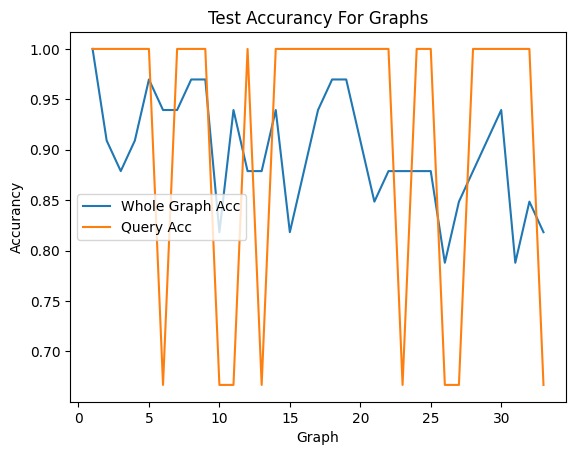

In [8]:
# GCN测试
def gcn_test(ensemble_gcn, time_graph_testloader, freq_graph_testloader, args:utils.Args):

    def get_acc(y_hat, y):
        return torch.sum(y_hat == y) / len(y)

    accs, query_accs = [], []
    with torch.no_grad():
        for graph_idx, (time_graph, freq_graph) in enumerate(zip(time_graph_testloader, freq_graph_testloader)):
            time_features, y = time_graph.x.to(args.device), time_graph.y.to(args.device)
            freq_features = freq_graph.x.to(args.device)
            edge_index, time_edge_weight = time_graph.edge_index.to(args.device), time_graph.edge_weight.to(args.device)
            freq_edge_weight = freq_graph.edge_weight.to(args.device)
            y_hat = ensemble_gcn(time_features, edge_index, time_edge_weight,
                                 freq_features, freq_edge_weight, y, args.N, args.query_size).argmax(axis=-1)
            accs.append(get_acc(y_hat, y).item()) # 整个测试图上预测正确率
            query_accs.append(get_acc(y_hat[-args.query_size:], y[-args.query_size:]).item()) # query_set中预测正确率
            print(f"在第 {graph_idx+1} 张测试图中, 整张图测试正确率为:{accs[-1]*100:.2f}%, Query集测试正确率为:{query_accs[-1]*100:.2f}%")
            
    print(f"在整体测试集上的平均正确率:{sum(accs) / len(accs)*100:.2f}%\n在Query测试集的平均正确率为:{sum(query_accs)/len(query_accs)*100:.2f}%")
    fig = plt.figure()
    plt.plot(list(range(1, len(time_graph_testloader)+1)), accs, label='Whole Graph Acc')
    plt.plot(list(range(1, len(time_graph_testloader)+1)), query_accs, label='Query Acc')
    plt.xlabel('Graph')
    plt.ylabel('Accurancy')
    plt.title('Test Accurancy For Graphs')
    plt.legend()
    res_folder = f"./Results/{args.N}-way-{args.K}-shots"
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    plt.savefig(os.path.join(res_folder, f"{args.SNR}SNR-gcn-test-res-{args.N}-way-{args.K}-shots-"+args.transform))
gcn_test(gcn, time_graph_testloader, freq_graph_testloader, args)